In [12]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


In [15]:
# specify learning params
batch_size = 264
learning_rate = 1e-3
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


### Clustering and PCA of the Random SimCLR model

In [72]:
def encode_batchwise(dataloader, model, device, layer, flatten=False):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    original = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        feats = model(batch_data, layer)
        original.append(batch)
        if flatten:
            embeddings.append(feats.flatten(start_dim=1).detach().cpu())
        else:
            embeddings.append(feats.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels, original

In [66]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=0.5, for_model='SimCLR')
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [67]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [17]:
# for i in range(3):
model = RotNet(num_classes=4, num_blocks=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet_e100.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print(model.feat_block_names)

['conv1', 'conv2', 'conv3', 'conv4', 'classifier']


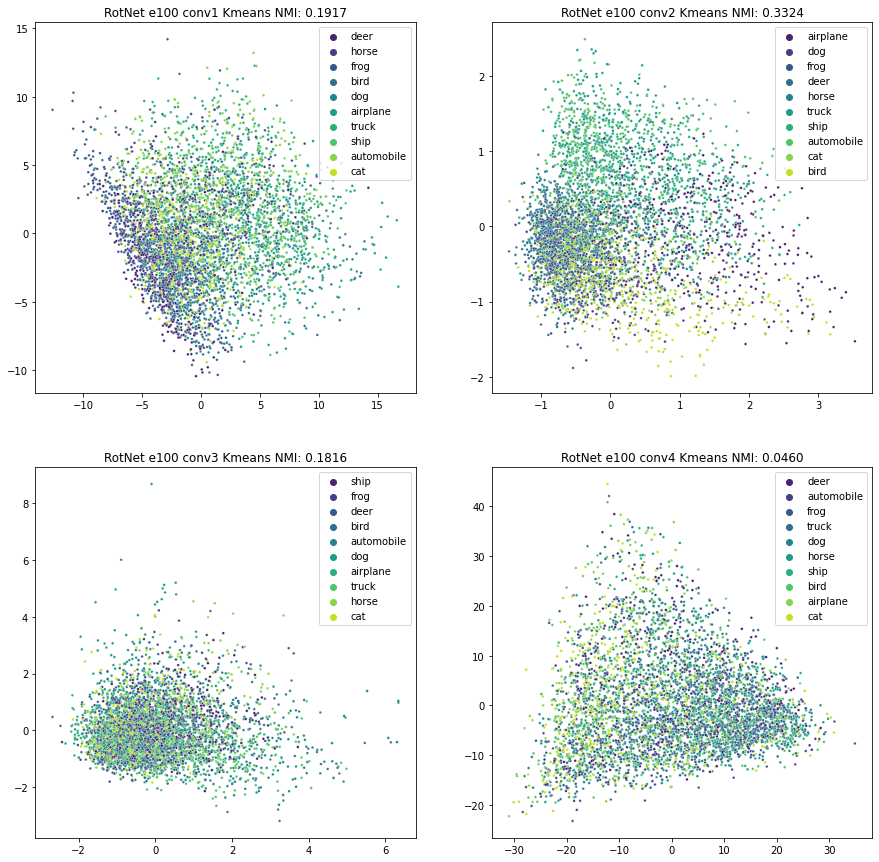

In [75]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()

for i, layer in enumerate(model.feat_block_names[:-1]):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels, _ = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

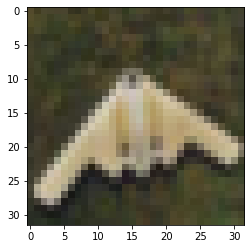

In [76]:
img, label = test_data.__getitem__(5)
plt.imshow(img.numpy().transpose(1,2,0))

In [77]:
img1 = img.unsqueeze(0).to(device)

img 5 conv1


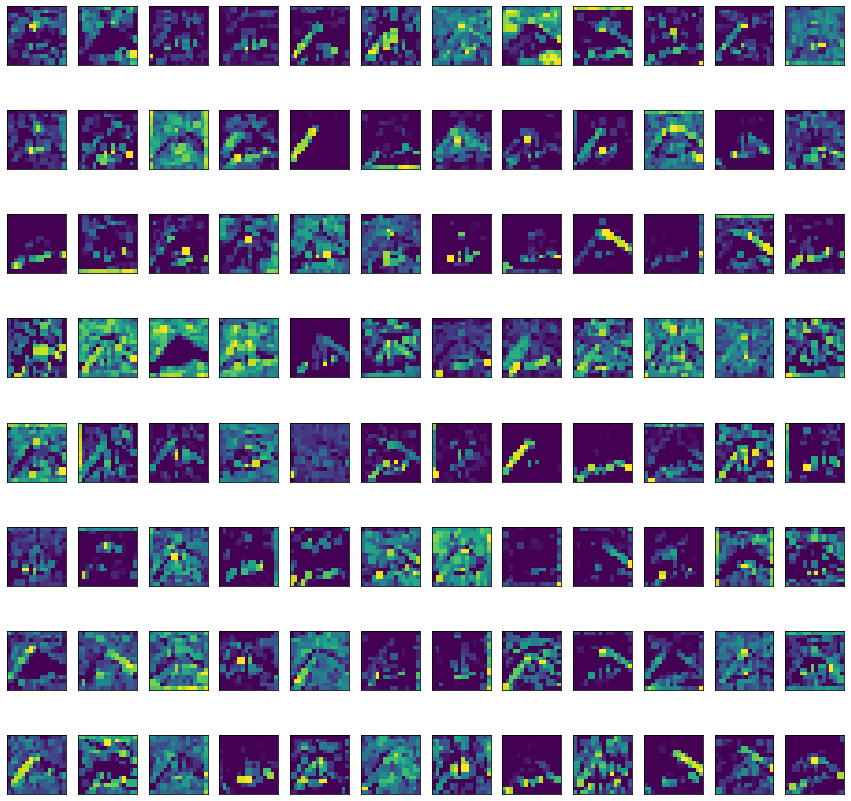

img 5 conv2


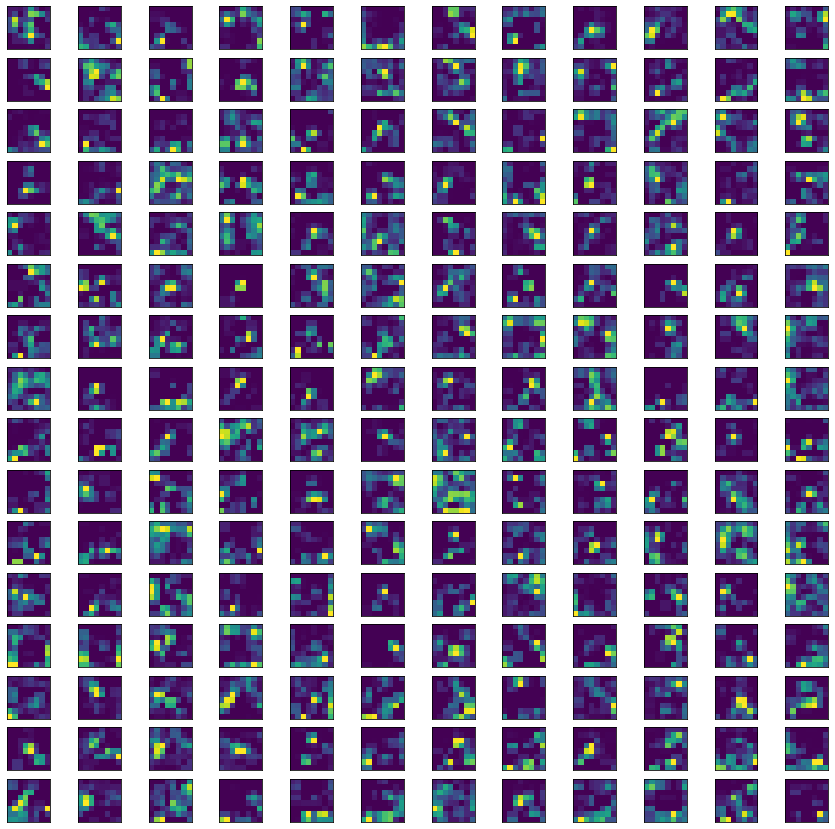

img 5 conv3


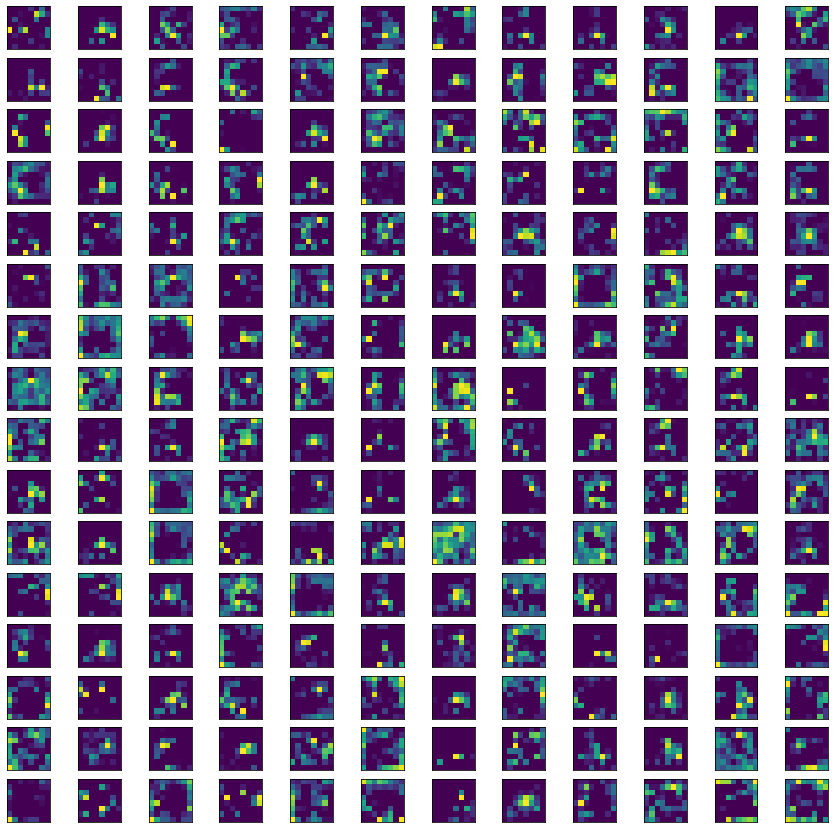

img 5 conv4


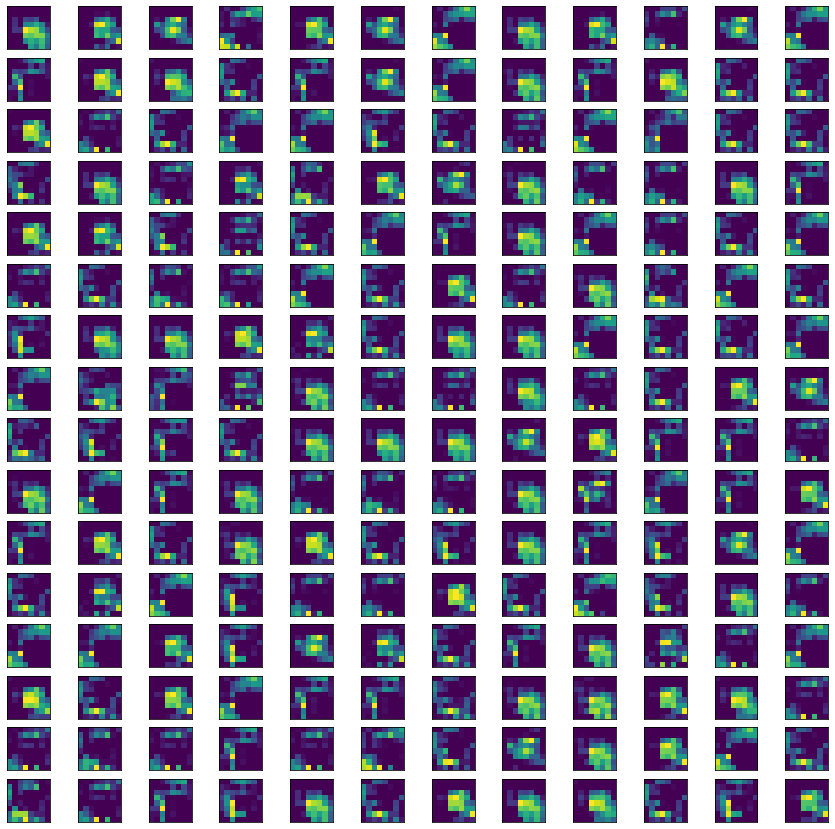

In [85]:
for i, layer in enumerate(model.feat_block_names[:-1]):
    print(f'img 5 {layer}')
    embedded_img = model(img1, [layer]).cpu().detach().numpy()[0]
    row_num = int(embedded_img.shape[0]/12)
    
    fig, axes = plt.subplots(row_num,12, figsize=(15,15))
    axes = axes.flatten()

    for i, img in enumerate(embedded_img):
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        axes[i].imshow(img)

    plt.show()

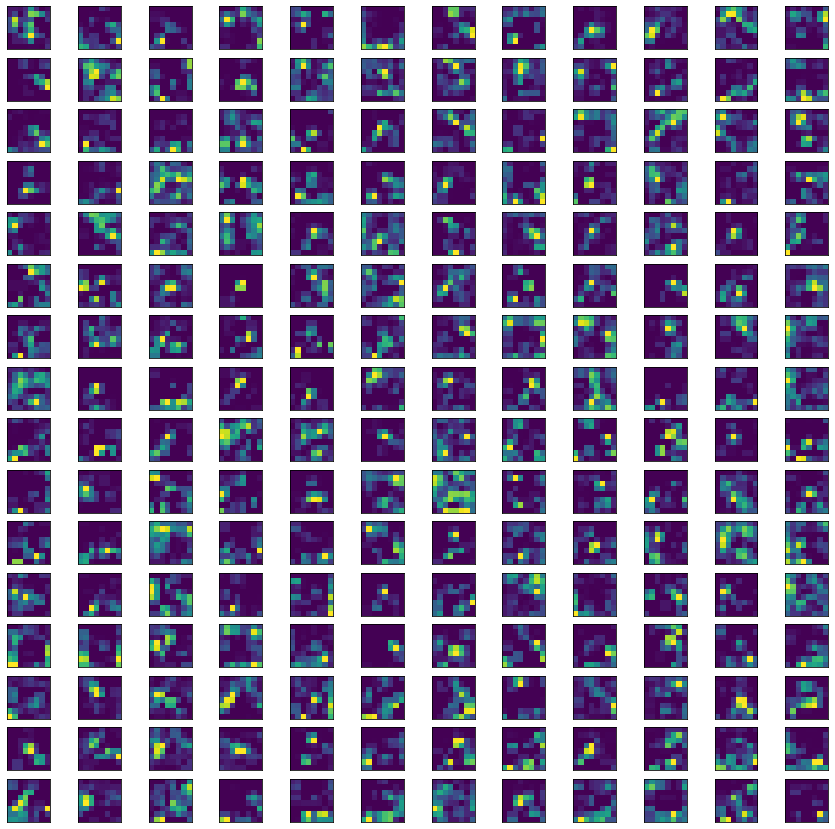

In [80]:
fig, axes = plt.subplots(16,12, figsize=(15,15))
axes = axes.flatten()

for i, img in enumerate(embedded_img):
    axes[i].tick_params(bottom=False, left=False)
    axes[i].set(xticklabels=[], yticklabels=[])
    axes[i].imshow(img)

plt.show()

### Loss statistics

In [324]:
epochs = pd.read_csv("stats/epoch_stat.csv", delimiter=',')
iteration = pd.read_csv("stats/iteration_stat.csv", delimiter=',')

In [325]:
epochs.head()

,epoch,iteration,loss
0,0,79,3.4439
1,1,158,3.2944
2,2,237,3.3587
3,3,316,3.0839
4,4,395,3.3050


In [326]:
iteration.head()

,epoch,iteration,loss
0,0,1,6.1647
1,0,2,6.1435
2,0,3,5.9987
3,0,4,5.9607
4,0,5,5.8656


In [327]:
def make_plots(df, x, y, kind, figsize, title, ylim, nrows=1, ncolumns=2):
    fig, axes = plt.subplots(nrows,ncolumns,figsize=figsize)
    axes[0].set_title(title)
    df.plot(ax = axes[0], x=x, y=y, kind=kind)
    axes[1].set_title(f'{title} (real scale)')
    df.plot(ax = axes[1], x=x, y=y, kind=kind, ylim=ylim)

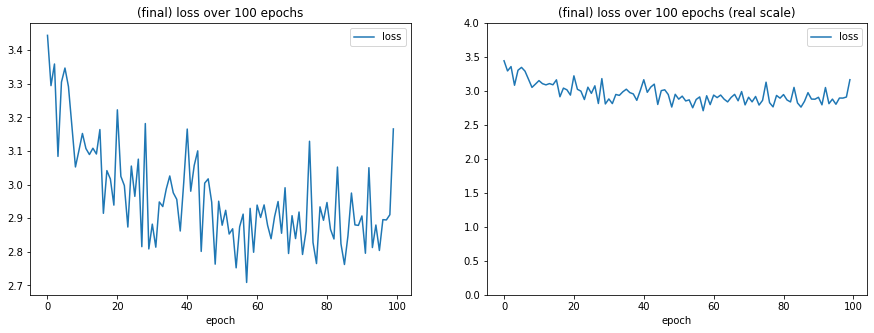

In [328]:
make_plots(df=epochs, x='epoch', y='loss', kind='line', ylim=(0,4), figsize=(15,5),
           title='(final) loss over 100 epochs')

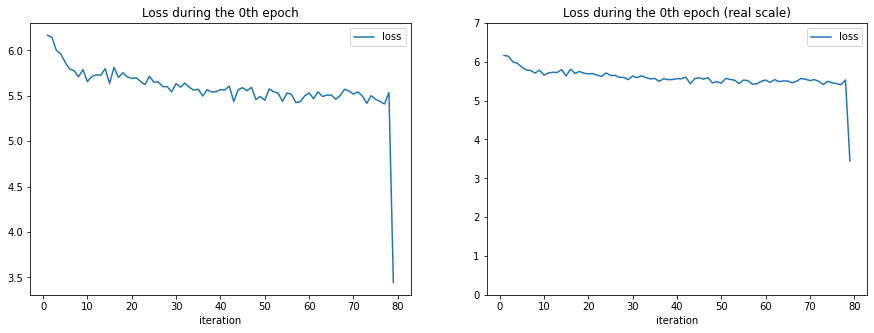

In [329]:
make_plots(df=iteration[iteration.epoch==0], x='iteration', y='loss', kind='line', ylim=(0,7), figsize=(15,5),
           title='Loss during the 0th epoch')

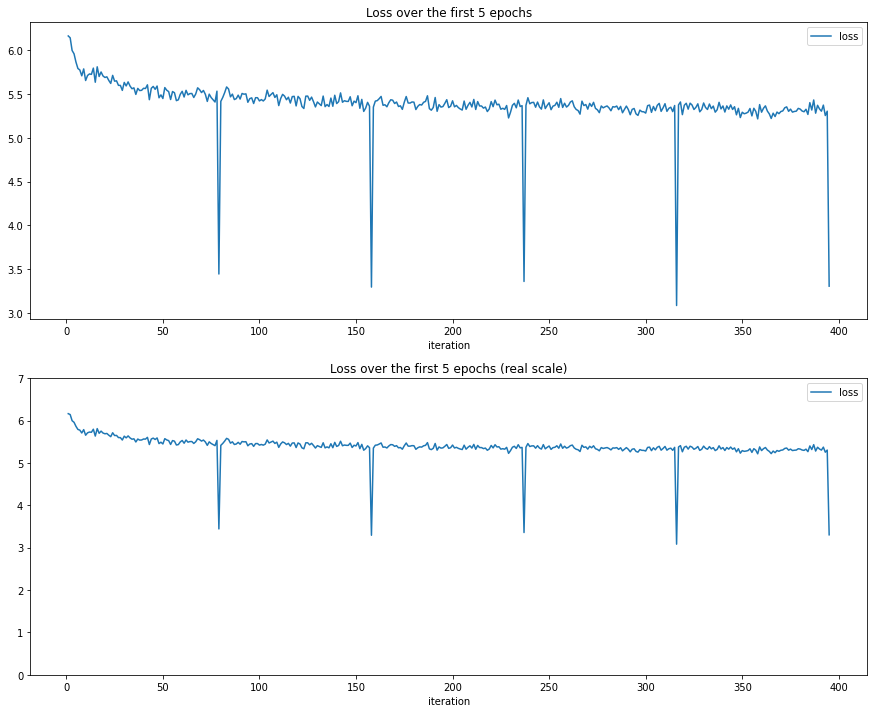

In [330]:
make_plots(df=iteration[iteration.epoch<5], x='iteration', y='loss', kind='line', ylim=(0,7), figsize=(15,12),
           nrows=2, ncolumns=1, title='Loss over the first 5 epochs')

This trend of loss being minimal at the end of the epoch continues over the whole training

In [331]:
it_epoch_group = iteration.groupby("epoch")["loss"].mean()

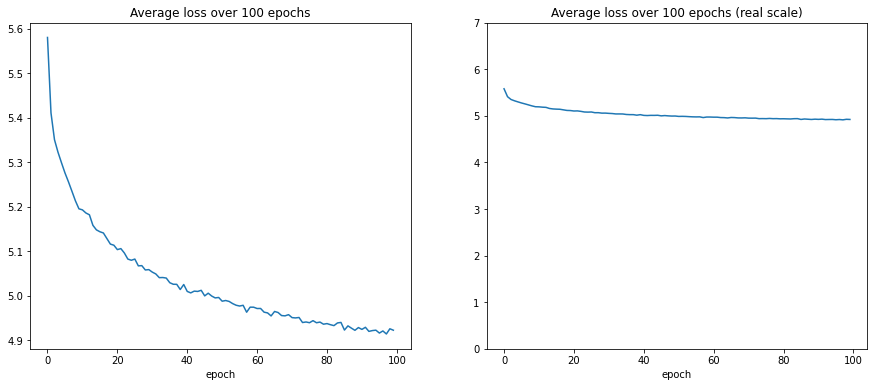

In [332]:
make_plots(df=it_epoch_group, x='epoch', y='loss', kind='line', ylim=(0,7), figsize=(15,6),
           title='Average loss over 100 epochs')

### Plot images

In [179]:
example_data = load_util.load_custom_cifar('./data', download=True, for_model='SimCLR', data_percent=1)

Files already downloaded and verified


In [210]:
def plot_pics(data, transpose, ids, nrow=8):
    pics = []
    for i in ids:
        pic = torch.from_numpy(np.transpose(data[i], transpose))
        pics.append(pic)
    plot_images(pics, nrow=nrow)

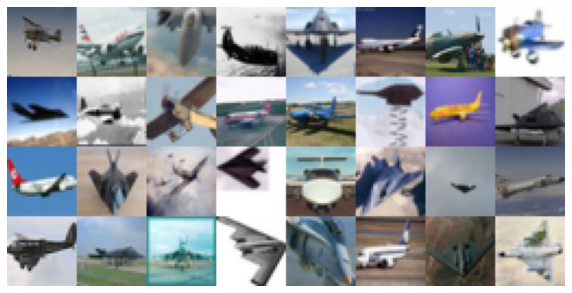

In [312]:
plot_pics(example_data.data[0], (2,0,1), range(32,64))

In [305]:
# loss from images put through random model; images are compared vs themselves
def compute_loss_from_model(data, model, loss, ids, transpose=(2,0,1)):
    pic_list = list([torch.from_numpy(np.transpose(data[i], transpose)) for i in ids])
    pics = torch.stack(pic_list).float()
    img, mapped_feats = model(pics)
    return loss(mapped_feats, mapped_feats)

In [341]:
# loss from flattened images; images are compared vs themselves
def compute_loss_from_img(data, loss, ids, transpose=(2,0,1)):
    pic_list = list([torch.from_numpy(np.transpose(data[i], transpose)).flatten() for i in ids])
    pics = torch.stack(pic_list).float()
    return loss(pics, pics)

In [378]:
# loss from 2 flatten images; 1st image is compared vs the second
def comparison_loss(data, model, loss, ids, transpose=(2,0,1)):
    pic_list = list([torch.from_numpy(np.transpose(data[i], transpose)).flatten().float() for i in ids])
    pics_0 = torch.stack([pic_list[0]]).float()
    pics_1 = torch.stack([pic_list[1]]).float()
    return loss(pics_0, pics_1)

In [318]:
loss = SimCLRLoss()
model = SimCLR(resnet_model='resnet18')

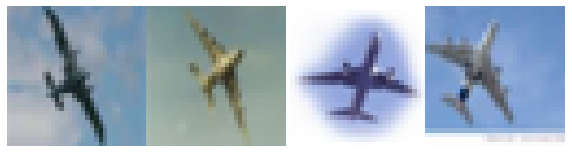

In [380]:
sim_ids = [28,29,65,139]
similar_ids = [[28,29], [28,65], [28,139], [29,65], [29,139], [65,139]]
plot_pics(example_data.data[0], (2,0,1), sim_ids)

Here I compared tensors of [Image1, Image1] vs [Image1, Image1] and then [Image1, Image1, Image1] vs [Image1, Image1, Image1]
Theoretically it should not go up, but it goes up a lot. I think this might be the source of the problem

In [377]:
print(f'Loss for same picture, 1 vs 1: {comparison_loss(example_data.data[0], model, loss, [28,28])}')

Loss for same picture, 1 vs 1: 0.0


In [375]:
print(f'Loss for same picture, 2 vs 2: {comparison_loss(example_data.data[0], model, loss, [28,28])}')

Loss for same picture, 2 vs 2: 1.0986123085021973


In [371]:
print(f'Loss for same picture, 3 vs 3: {comparison_loss(example_data.data[0], model, loss, [28,28])}')

Loss for same picture: 1.6094379425048828


In [381]:
losses = []
for ids in similar_ids:
    l = comparison_loss(example_data.data[0], model, loss, ids)
    losses.append(l)
    print(f'Compared pics: {ids}, loss: {l}')
print(f'Losses avg: {sum(losses)/len(losses)}')
print(f'Compared pics: {sim_ids}, loss: {compute_loss_from_img(example_data.data[0], loss, sim_ids)}')

Compared pics: [28, 29], loss: 0.057291679084300995
Compared pics: [28, 65], loss: 0.08470192551612854
Compared pics: [28, 139], loss: 0.07774117588996887
Compared pics: [29, 65], loss: 0.06956791877746582
Compared pics: [29, 139], loss: 0.07252601534128189
Compared pics: [65, 139], loss: 0.09531791508197784
Losses avg: 0.07619110494852066
Compared pics: [28, 29, 65, 139], loss: 1.8810091018676758


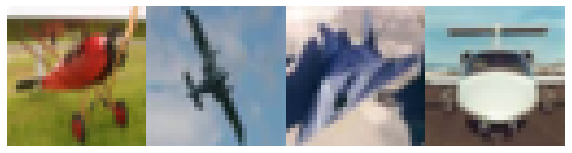

In [382]:
non_sim_ids = [2,28,53,52]
non_similar_ids = [[2,28], [2,53], [2,52], [28,53], [28,52], [52,53]]
plot_pics(example_data.data[0], (2,0,1), non_sim_ids)

In [383]:
losses = []
for ids in non_similar_ids:
    l = comparison_loss(example_data.data[0], model, loss, ids)
    losses.append(l)
    print(f'Compared pics: {ids}, loss: {l}')
print(f'Losses avg: {sum(losses)/len(losses)}')
print(f'Compared pics: {non_sim_ids}, loss: {compute_loss_from_img(example_data.data[0], loss, non_sim_ids)}')

Compared pics: [2, 28], loss: 0.3504856824874878
Compared pics: [2, 53], loss: 0.4104524850845337
Compared pics: [2, 52], loss: 0.32205402851104736
Compared pics: [28, 53], loss: 0.2606598138809204
Compared pics: [28, 52], loss: 0.2896244525909424
Compared pics: [52, 53], loss: 0.2780005931854248
Losses avg: 0.3185461759567261
Compared pics: [2, 28, 53, 52], loss: 1.6803791522979736


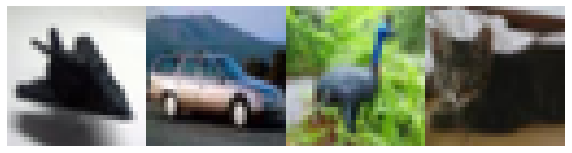

In [384]:
non_sim_data = list([example_data.data[i][0] for i in range(4)])
non_sim_ids = list(range(4))
non_similar_ids = [[0,1],[0,2],[0,3], [1,2], [1,3], [2,3]]
plot_pics(non_sim_data, (2,0,1), range(4))

In [385]:
losses = []
for ids in non_similar_ids:
    l = comparison_loss(non_sim_data, model, loss, ids)
    losses.append(l)
    print(f'Compared pics: {ids}, loss: {l}')
print(f'Losses avg: {sum(losses)/len(losses)}')
print(f'Compared pics: {non_sim_ids}, loss: {compute_loss_from_img(non_sim_data, loss, non_sim_ids)}')

Compared pics: [0, 1], loss: 0.5537188053131104
Compared pics: [0, 2], loss: 0.37526798248291016
Compared pics: [0, 3], loss: 0.4226030707359314
Compared pics: [1, 2], loss: 0.43207454681396484
Compared pics: [1, 3], loss: 0.5345945358276367
Compared pics: [2, 3], loss: 0.5205551385879517
Losses avg: 0.47313570976257324
Compared pics: [0, 1, 2, 3], loss: 1.5571730136871338
